# Introduction

The goal of this script is to test differetn thresholding/ segmentation/ counting strategies to find the beest implementaions to count the progenitor cell in *Drosophila*. 

In the end, we settled with LoG filter, which can detect the cells very accurately and it will be the basics for automating progenitor cell counting for **Sokol Lab**.

Shengyao Chen

In [2]:
# import the modules that we need and specify the folder which contains the files
import pandas as pd
import glob, os
import numpy as np
import matplotlib as mpl

from pylab import imshow
from skimage import io
import skimage
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

In [3]:
current_path = %pwd
% ls

MAX_stackwt1.tif                drosophila_counting.ipynb
MAX_stackwt1_analysis.png       drosophila_counting_demo.ipynb
MAX_stackwt2.tif                measurement_result.csv
MAX_stackwt2_analysis.png


In [4]:
image = io.imread('MAX_stackwt1.tif')
image.shape

(3, 1040, 1388, 3)

# This part read the Max image and parse out the blue and green channel #

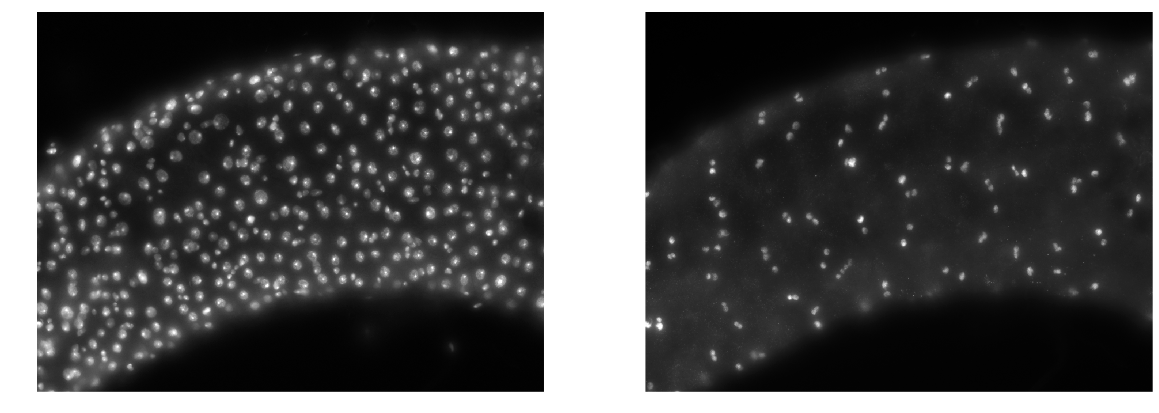

In [5]:
DNA = image[2, ..., 0]
green = image[1, ..., 0]

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 15))
ax1.imshow(DNA)
ax2.imshow(green)
ax1.set_axis_off()
ax2.set_axis_off()

# This is the previous approach to count the nuclei

However, this is not the best approach.

171


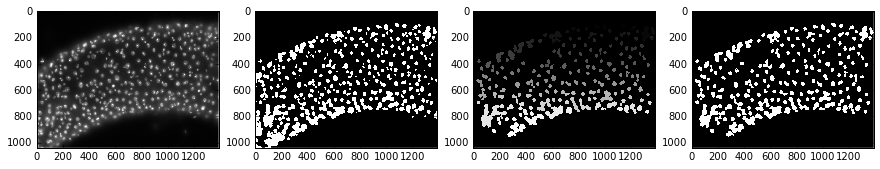

In [6]:
# DNAf = mh.gaussian_filter(DNA, 1)
DNAf = (DNA > mh.otsu(DNA) * 1.1)

labeled, numberOfNuclei = mh.label(DNAf)
original_label = labeled

max_size = 20000
min_size = 500

sizes = mh.labeled.labeled_size(labeled)

too_big = np.where(sizes > max_size)
labeled = mh.labeled.remove_regions(labeled, too_big)

too_small = np.where(sizes < min_size)
labeled = mh.labeled.remove_regions(labeled, too_small)

# Remove cells at the borders
labeled = mh.labeled.remove_bordering(labeled)

# Relabel everthing
relabeled, n_nuclei = mh.labeled.relabel(labeled)

relabeledf = (relabeled > 0)

fig, (ax_original, ax_filter, ax_label, ax_relabel) = plt.subplots(ncols = 4, figsize = (15,10))
ax_original.imshow(DNA, cmap = 'gray')
ax_filter.imshow(DNAf, cmap = 'gray')
ax_label.imshow(relabeled)
ax_relabel.imshow(relabeledf)
print(n_nuclei)

# Blob detection of nuclei

Since we do not need to measure the size of each nuclei, I believe that using blob detecting is better for counting.
Notice that the ** 'Laplacian of Gaussian' ** seems to be the best way.

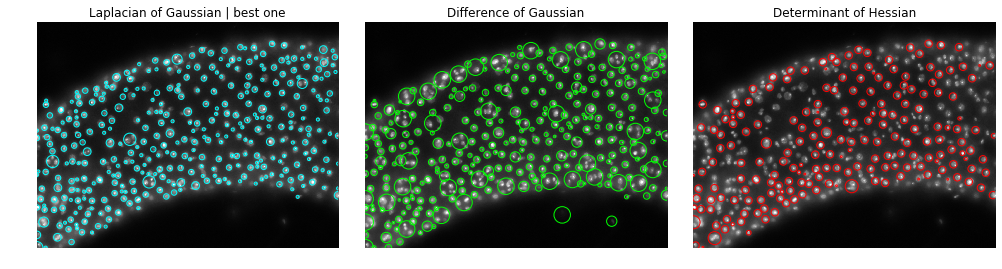

In [7]:
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray

blobs_log = blob_log(DNA, max_sigma=20, min_sigma = 5, num_sigma=5, overlap = 0.1, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(DNA, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(DNA, max_sigma=30, threshold=.005)
blobs_list = [blobs_log, blobs_dog, blobs_doh]

colors = ['cyan', 'lime', 'red']
titles = ['Laplacian of Gaussian | best one', 'Difference of Gaussian',
          'Determinant of Hessian']

sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
plt.tight_layout()

axes = axes.ravel()
for blobs, color, title in sequence:
    ax = axes[0]
    axes = axes[1:]
    ax.set_title(title)
    ax.imshow(DNA, interpolation='nearest')
    ax.set_axis_off()
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
        ax.add_patch(c)


In [8]:
print('The number of nuclei counted is ' + str(len(blobs_log)))

The number of nuclei counted is 368


** my manu count is 364**, not bad.

# The next part is counting the green dots.
again, 'Laplacian of Gaussian' seems to be the best way.

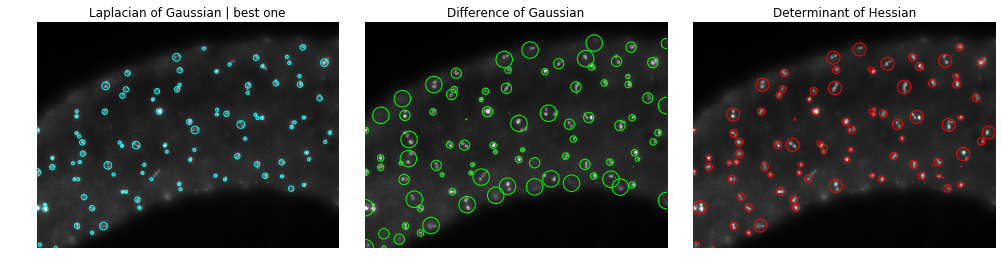

In [9]:
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray

blobs_log = blob_log(green, max_sigma=20, min_sigma = 5, num_sigma=5, overlap = 0.1, threshold=.1)
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(green, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(green, max_sigma=30, threshold=.001)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['cyan', 'lime', 'red']
titles = ['Laplacian of Gaussian | best one', 'Difference of Gaussian',
          'Determinant of Hessian']

sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
plt.tight_layout()

axes = axes.ravel()
for blobs, color, title in sequence:
    ax = axes[0]
    axes = axes[1:]
    ax.set_title(title)
    ax.imshow(green, interpolation='nearest')
    ax.set_axis_off()
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
        ax.add_patch(c)


In [10]:
print('The number of green dots is ' + str(len(blobs_log)))

The number of green dots is 95


my ** manu count is 107**, again, not bad

*Overall, I am happy with the Laplacian of Gaussian blob detection right now.*

393 114


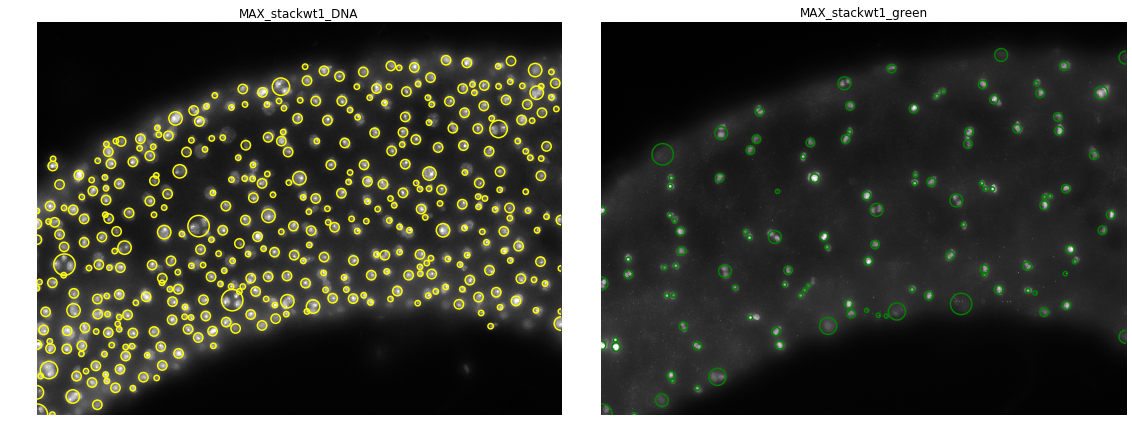

In [13]:
def blob_counting(file):
    image = io.imread(file)
    DNA = image[2, ..., 0]
    green = image[1, ..., 0]
    
    dna_blobs_log = blob_log(DNA, max_sigma=20, min_sigma = 5, num_sigma=5, overlap = 0.5, threshold=.08)
    dna_blobs_log[:, 2] = dna_blobs_log[:, 2] * sqrt(2)
    
    green_blobs_log = blob_log(green, max_sigma=20, min_sigma = 4, num_sigma=5, overlap = 0.5, threshold=.04)
    green_blobs_log[:, 2] = green_blobs_log[:, 2] * sqrt(2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True,
                             subplot_kw={'adjustable': 'box-forced'})
    plt.tight_layout()
    
    ax1.imshow(DNA, interpolation = 'nearest')
    ax1.set_axis_off()
    ax1.set_title(file.split('.')[0] + '_DNA')
    for blob in dna_blobs_log:
        y, x, r = blob
        c = plt.Circle((x, y), r, color= 'yellow', linewidth=1.5, fill=False)
        ax1.add_patch(c)
        
    ax2.imshow(green, interpolation = 'nearest')
    ax2.set_axis_off()
    ax2.set_title(file.split('.')[0] + '_green')
    for blob in green_blobs_log:
        y, x, r = blob
        c = plt.Circle((x, y), r, color= 'green', linewidth=1.5, fill=False)
        ax2.add_patch(c)
    fig.savefig(file.split('.')[0] + '_analysis')
    
    return [len(dna_blobs_log), len(green_blobs_log)]

In [14]:
current_path = %pwd
file_list = os.listdir(current_path)
file_list = [i for i in file_list if i[:3] == 'MAX' and i[-3:] == 'tif']
print(file_list)

['MAX_stackwt1.tif', 'MAX_stackwt2.tif']


{'MAX_stackwt1': [393, 114], 'MAX_stackwt2': [460, 125]}
CPU times: user 10.9 s, sys: 760 ms, total: 11.7 s
Wall time: 12.1 s


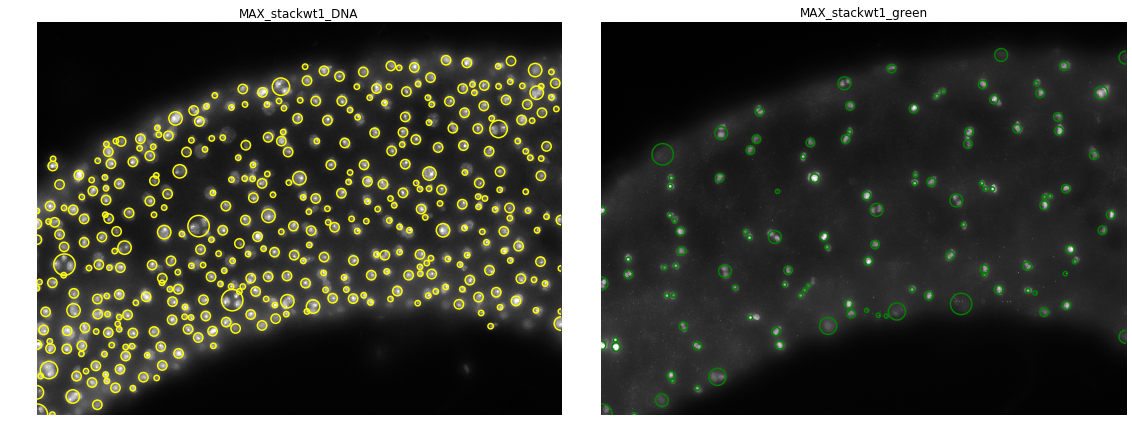

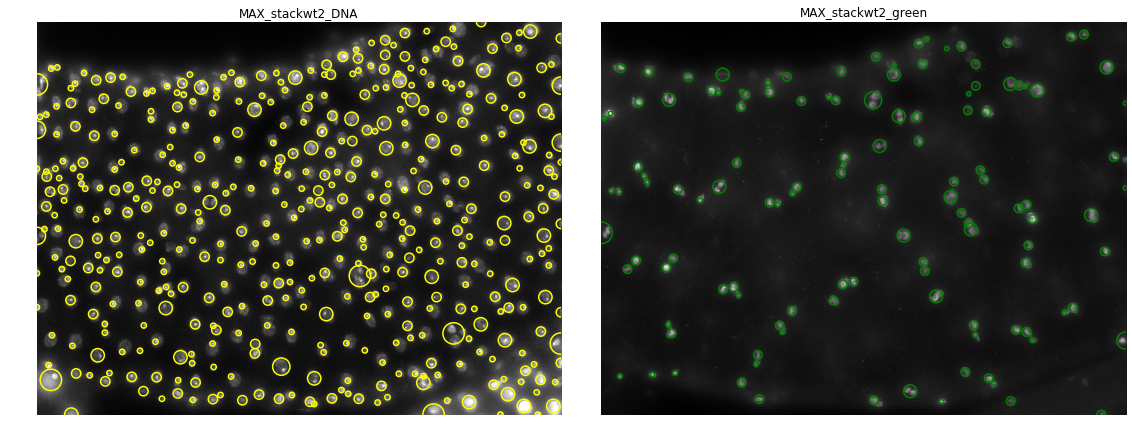

In [15]:
%%time

result_dictionary = {}
for file in file_list:
    result_dictionary[file.split('.')[0]] = blob_counting(file)

print(result_dictionary)

In [130]:
import pandas as pd

analysis = pd.DataFrame(result_dictionary, index = ['blue', 'green'])
analysis['summary'] = analysis.sum(axis = 1)

In [131]:
analysis.to_csv('measurement_result.csv')

TypeError: describe() got an unexpected keyword argument 'axis'